In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SPDR Bloomberg High Yield Bond ETF (JNK).csv')
data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,GDP,FEDFUNDS,Unemployment rate,Inflation
0,0,2014-01-02,121.800003,121.800003,121.410004,121.589996,67.203178,1422267,17953.974,0.07,6.6,-1.797000
1,1,2014-01-03,121.739998,121.860001,121.620003,121.680000,67.252922,763967,17953.974,0.07,6.6,-1.797000
2,2,2014-01-06,121.919998,122.010002,121.769997,121.919998,67.385567,1097633,17953.974,0.07,6.6,-1.797000
3,3,2014-01-07,121.980003,122.070000,121.919998,121.949997,67.402176,1112333,17953.974,0.07,6.6,-1.797000
4,4,2014-01-08,121.860001,122.010002,121.860001,121.919998,67.385567,1368900,17953.974,0.07,6.6,-1.797000
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,2597,2024-04-29,93.769997,94.019997,93.769997,94.019997,93.477592,5915000,22768.866,5.33,3.9,-0.084586
2598,2598,2024-04-30,93.720001,93.919998,93.379997,93.430000,92.890999,9199700,22768.866,5.33,3.9,-0.084586
2599,2599,2024-05-01,92.849998,93.699997,92.849998,93.300003,93.300003,12350300,22768.866,5.33,3.9,-0.084586
2600,2600,2024-05-02,93.500000,93.870003,93.320000,93.839996,93.839996,6454500,22768.866,5.33,3.9,-0.084586


In [ ]:
data = data.drop(columns =['Unnamed: 0'])

#Data preprocessing and feature engineering

In [ ]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
# Create time-based features using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Day_of_Week'] = data['Date'].dt.dayofweek
data.loc[:, 'Month'] = data['Date'].dt.month
data.loc[:, 'Quarter'] = data['Date'].dt.quarter
data.loc[:, 'Year'] = data['Date'].dt.year
# Check for missing values
missing_values = data.isnull().sum()

# Display missing values
missing_values

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
GDP,0
FEDFUNDS,0
Unemployment rate,0


In [ ]:
# Create moving averages
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Create lag features
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)

# Create daily returns features
data['Daily Return'] = data['Close'].pct_change()

# Drop rows with NaN values due to rolling and shifting operations
data = data.dropna()

# Display the first few rows to check the new features
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,GDP,FEDFUNDS,Unemployment rate,...,Month,Quarter,Year,MA10,MA20,MA50,Lag1,Lag2,Lag3,Daily Return
49,2014-03-14,123.029999,123.209999,122.970001,122.970001,68.631279,932900,17953.974,0.08,6.7,...,3,1,2014,123.471001,123.534000,122.7138,123.150002,123.330002,123.300003,-0.001462
50,2014-03-17,123.150002,123.300003,123.089996,123.089996,68.698212,933800,17953.974,0.08,6.7,...,3,1,2014,123.405001,123.544500,122.7438,122.970001,123.150002,123.330002,0.000976
51,2014-03-18,123.300003,123.570000,123.239998,123.480003,68.915886,1085400,17953.974,0.08,6.7,...,3,1,2014,123.348001,123.568500,122.7798,123.089996,122.970001,123.150002,0.003168
52,2014-03-19,123.599998,123.629997,122.910004,123.059998,68.681526,2661733,17953.974,0.08,6.7,...,3,1,2014,123.258001,123.577501,122.8026,123.480003,123.089996,122.970001,-0.003401
53,2014-03-20,122.970001,123.480003,122.970001,123.480003,68.915886,1118267,17953.974,0.08,6.7,...,3,1,2014,123.240001,123.589501,122.8332,123.059998,123.480003,123.089996,0.003413


In [ ]:
# Manually adding some common technical indicators and time-based features

# Relative Strength Index (RSI)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = RSI(data['Close'])

# Moving Average Convergence Divergence (MACD)
def MACD(series, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = series.ewm(span=fast_period, min_periods=1, adjust=False).mean()
    slow_ema = series.ewm(span=slow_period, min_periods=1, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, min_periods=1, adjust=False).mean()
    return macd, signal

data['MACD'], data['MACD_Signal'] = MACD(data['Close'])

# Bollinger Bands
def Bollinger_Bands(series, period=20, std_dev=2):
    sma = series.rolling(window=period, min_periods=1).mean()
    std = series.rolling(window=period, min_periods=1).std()
    upper_band = sma + (std_dev * std)
    lower_band = sma - (std_dev * std)
    return upper_band, lower_band

data['Bollinger_Upper'], data['Bollinger_Lower'] = Bollinger_Bands(data['Close'])
# Display the first few rows of the dataset with added features
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,GDP,FEDFUNDS,Unemployment rate,...,MA50,Lag1,Lag2,Lag3,Daily Return,RSI,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower
49,2014-03-14,123.029999,123.209999,122.970001,122.970001,68.631279,932900,17953.974,0.08,6.7,...,122.7138,123.150002,123.330002,123.300003,-0.001462,NaN,0.000000,0.000000,NaN,NaN
50,2014-03-17,123.150002,123.300003,123.089996,123.089996,68.698212,933800,17953.974,0.08,6.7,...,122.7438,122.970001,123.150002,123.330002,0.000976,100.000000,0.009572,0.001914,123.199697,122.860300
51,2014-03-18,123.300003,123.570000,123.239998,123.480003,68.915886,1085400,17953.974,0.08,6.7,...,122.7798,123.089996,122.970001,123.150002,0.003168,100.000000,0.048074,0.011146,123.713296,122.646704
52,2014-03-19,123.599998,123.629997,122.910004,123.059998,68.681526,2661733,17953.974,0.08,6.7,...,122.8026,123.480003,123.089996,122.970001,-0.003401,54.838512,0.044187,0.017755,123.601667,122.698332
53,2014-03-20,122.970001,123.480003,122.970001,123.480003,68.915886,1118267,17953.974,0.08,6.7,...,122.8332,123.059998,123.480003,123.089996,0.003413,68.888795,0.074143,0.029032,123.706025,122.725975


#Descriptive Statistics about the Data

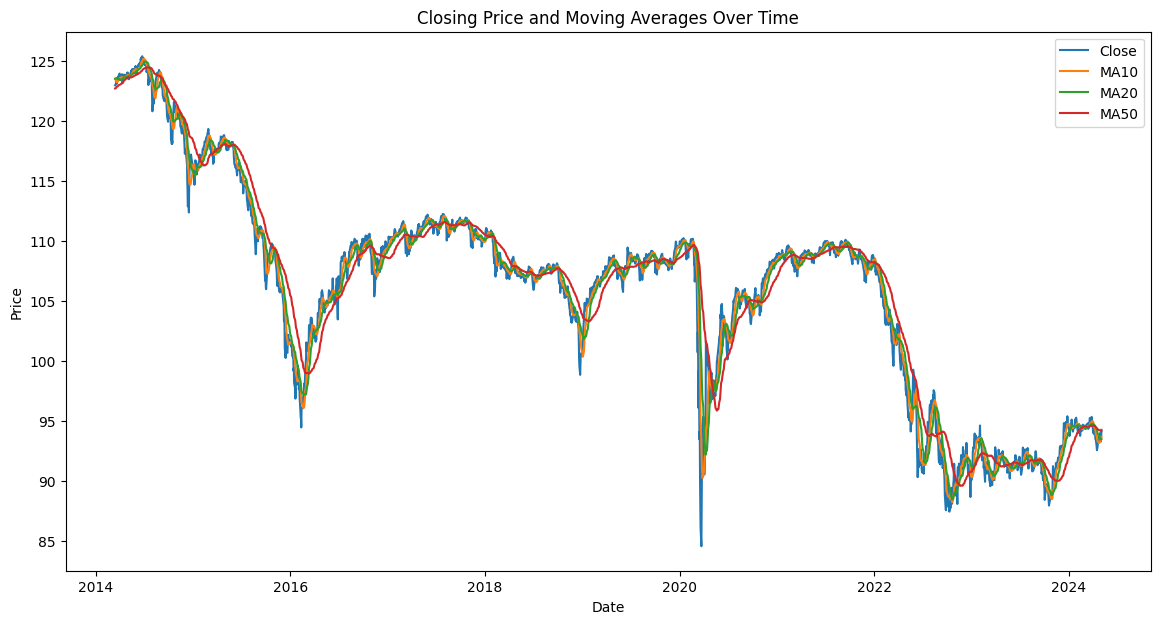

In [ ]:
# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close')
plt.plot(data['Date'], data['MA10'], label='MA10')
plt.plot(data['Date'], data['MA20'], label='MA20')
plt.plot(data['Date'], data['MA50'], label='MA50')
plt.title('Closing Price and Moving Averages Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
#plt.savefig('Macintosh HD/Users/philippeyao/Downloads/closing_price_moving_averages.png')
plt.show()


In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'GDP',
       'FEDFUNDS', 'Unemployment rate', 'Inflation', 'Day_of_Week', 'Month',
       'Quarter', 'Year', 'MA10', 'MA20', 'MA50', 'Lag1', 'Lag2', 'Lag3',
       'Daily Return', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper',
       'Bollinger_Lower'],
      dtype='object')

In [ ]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,GDP,FEDFUNDS,Unemployment rate,...,MA50,Lag1,Lag2,Lag3,Daily Return,RSI,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower
count,2553,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2.553000e+03,2553.000000,2553.000000,2553.000000,...,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2552.000000,2553.000000,2553.000000,2552.000000,2552.000000
mean,2019-04-07 23:48:43.149236224,105.977897,106.215123,105.728296,105.980262,79.397805,5.928031e+06,20383.146646,1.435033,4.825460,...,106.259905,105.991575,106.003126,106.014877,-0.000090,49.870224,-0.079870,-0.079538,107.662126,104.506333
min,2014-03-14 00:00:00,86.309998,86.669998,83.180000,84.570000,58.984715,4.162670e+05,17953.974000,0.050000,3.400000,...,89.598800,84.570000,84.570000,84.570000,-0.057572,2.247081,-5.709377,-4.601183,89.862816,81.348843
25%,2016-09-23 00:00:00,101.279999,101.760002,100.790001,101.260002,71.021591,2.991700e+06,19062.709000,0.100000,3.700000,...,101.802801,101.330002,101.339996,101.430000,-0.002189,37.835867,-0.316834,-0.292429,104.204605,98.791359
50%,2019-04-09 00:00:00,107.820000,107.980003,107.669998,107.839996,78.913414,4.991400e+06,20415.150000,0.660000,4.300000,...,107.879800,107.839996,107.849998,107.849998,0.000000,49.860902,0.022524,0.015185,109.017918,106.766393
75%,2021-10-19 00:00:00,110.129997,110.250000,109.919998,110.110001,86.003922,7.776633e+06,21708.160000,2.190000,5.400000,...,110.221800,110.120003,110.129997,110.129997,0.002075,61.940806,0.236997,0.214643,111.231535,109.175645
max,2024-05-03 00:00:00,125.339996,125.459999,125.250000,125.400002,94.293060,4.617500e+07,22768.866000,5.330000,14.800000,...,124.485000,125.400002,125.400002,125.400002,0.067087,100.000000,1.718526,1.445703,125.931936,124.353678
std,NaN,8.707500,8.630979,8.767260,8.695917,8.647354,4.190470e+06,1330.775370,1.684350,1.745508,...,8.625708,8.699461,8.702898,8.705992,0.005458,17.114112,0.609404,0.567486,8.381498,9.160017


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2553 entries, 49 to 2601
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2553 non-null   datetime64[ns]
 1   Open               2553 non-null   float64       
 2   High               2553 non-null   float64       
 3   Low                2553 non-null   float64       
 4   Close              2553 non-null   float64       
 5   Adj Close          2553 non-null   float64       
 6   Volume             2553 non-null   int64         
 7   GDP                2553 non-null   float64       
 8   FEDFUNDS           2553 non-null   float64       
 9   Unemployment rate  2553 non-null   float64       
 10  Inflation          2553 non-null   float64       
 11  Day_of_Week        2553 non-null   int32         
 12  Month              2553 non-null   int32         
 13  Quarter            2553 non-null   int32         
 14  Year        

# Trends

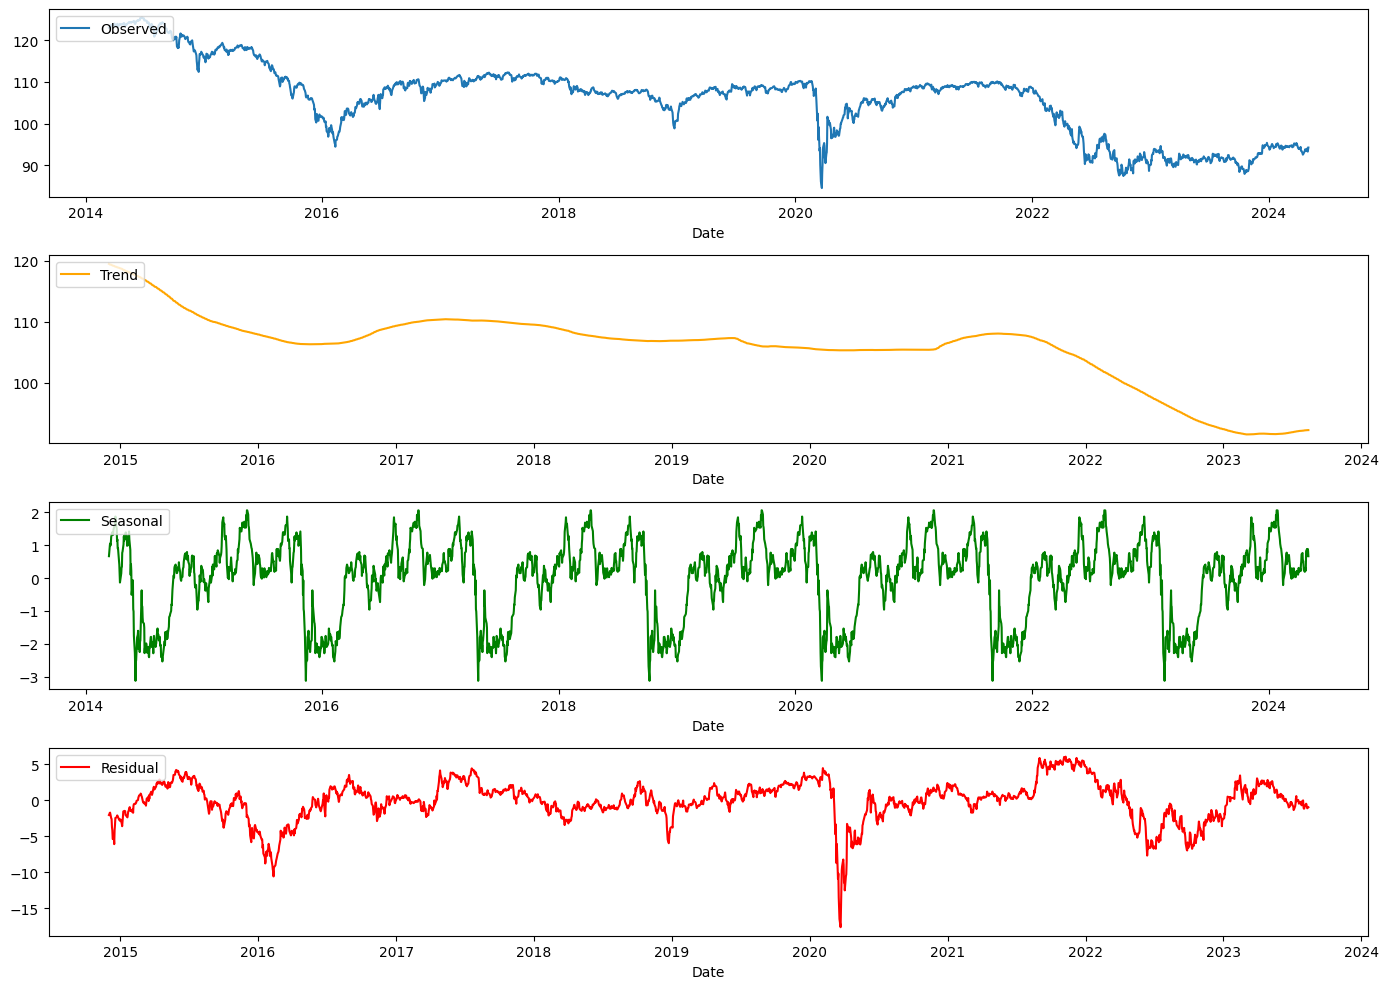

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the dataset is loaded into a DataFrame named 'data'
# data = pd.read_csv('your_dataset.csv')  # Example for loading data

# Performing seasonal decomposition
data.set_index('Date', inplace=True)
result = seasonal_decompose(data['Close'], model='additive', period=365)

# Plotting the results
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.xlabel('Date')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.xlabel('Date')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.xlabel('Date')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.xlabel('Date')

plt.tight_layout()
plt.savefig('seasonal_decomposition.png')
plt.show()


#Data Visualization

In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'GDP',
       'FEDFUNDS', 'Unemployment rate', 'Inflation', 'Day_of_Week', 'Month',
       'Quarter', 'Year', 'MA10', 'MA20', 'MA50', 'Lag1', 'Lag2', 'Lag3',
       'Daily Return', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper',
       'Bollinger_Lower'],
      dtype='object')

In [ ]:
min_daily_return = data['Daily Return'].min()
max_daily_return = data['Daily Return'].max()
min_date = data.loc[data['Daily Return'].idxmin(), 'Date']
max_date = data.loc[data['Daily Return'].idxmax(), 'Date']


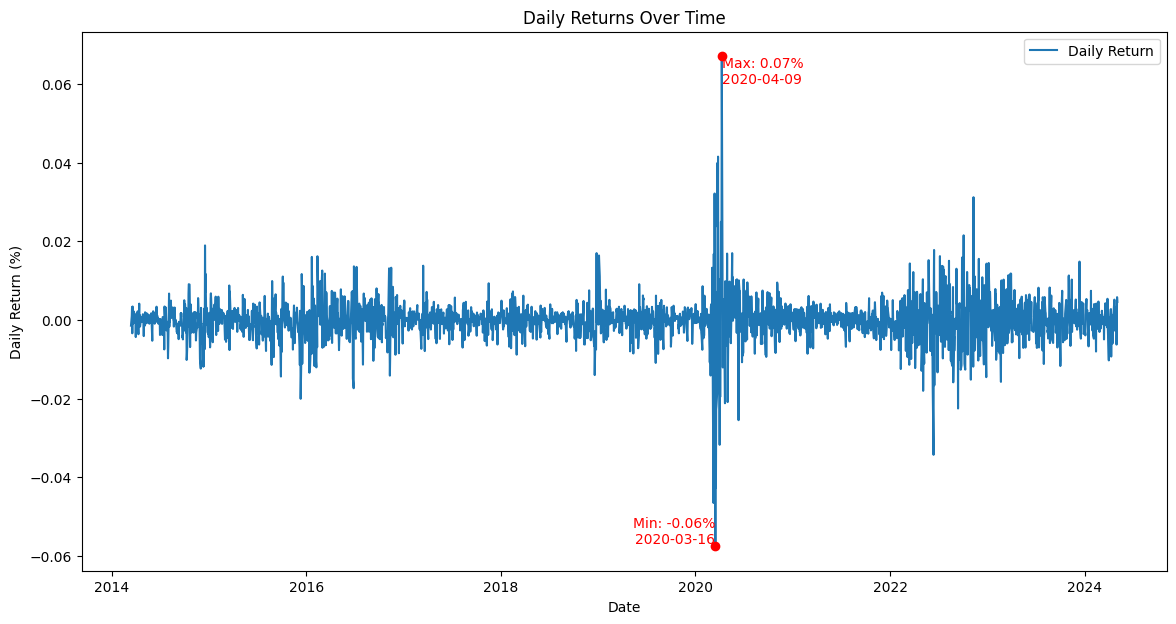

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Daily Return'], label='Daily Return')
plt.scatter([min_date, max_date], [min_daily_return, max_daily_return], color='red', zorder=5)
plt.text(min_date, min_daily_return, f'Min: {min_daily_return:.2f}%\n{min_date.date()}',
         horizontalalignment='right', verticalalignment='bottom', color='red')
plt.text(max_date, max_daily_return, f'Max: {max_daily_return:.2f}%\n{max_date.date()}',
         horizontalalignment='left', verticalalignment='top', color='red')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.show()


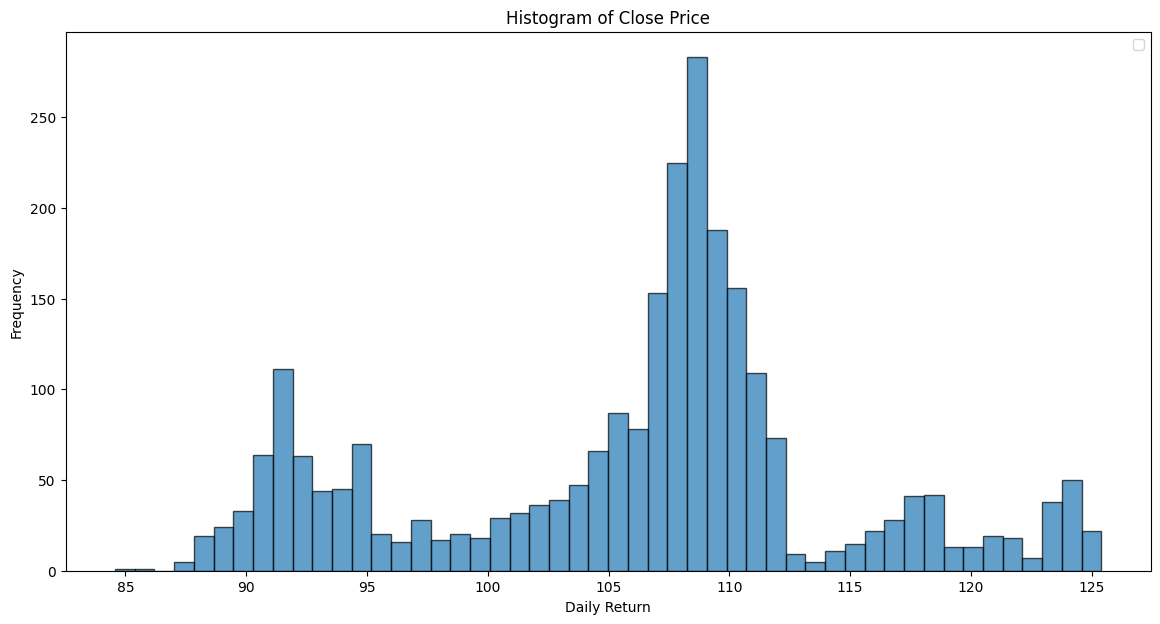

In [ ]:
# Calculate the mean daily return
#mean_daily_return = data['Daily Return'].mean()

# Plot histogram of daily returns
plt.figure(figsize=(14, 7))
plt.hist(data['Close'], bins=50, edgecolor='k', alpha=0.7)
#plt.axvline(data['Close'], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {data['Close']:.4f}%\n')
plt.title('Histogram of Close Price')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('close_price_distribution')
plt.show()

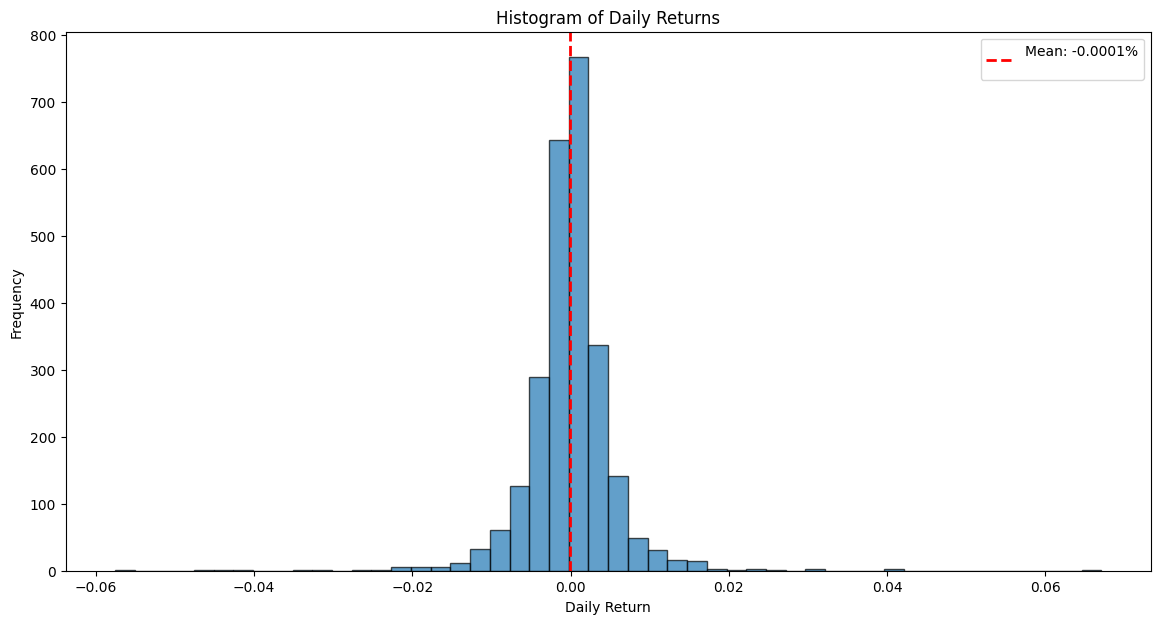

In [ ]:
# Calculate the mean daily return
mean_daily_return = data['Daily Return'].mean()

# Plot histogram of daily returns
plt.figure(figsize=(14, 7))
plt.hist(data['Daily Return'], bins=50, edgecolor='k', alpha=0.7)
plt.axvline(mean_daily_return, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_daily_return:.4f}%\n')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('daily_returns_distribution')
plt.show()

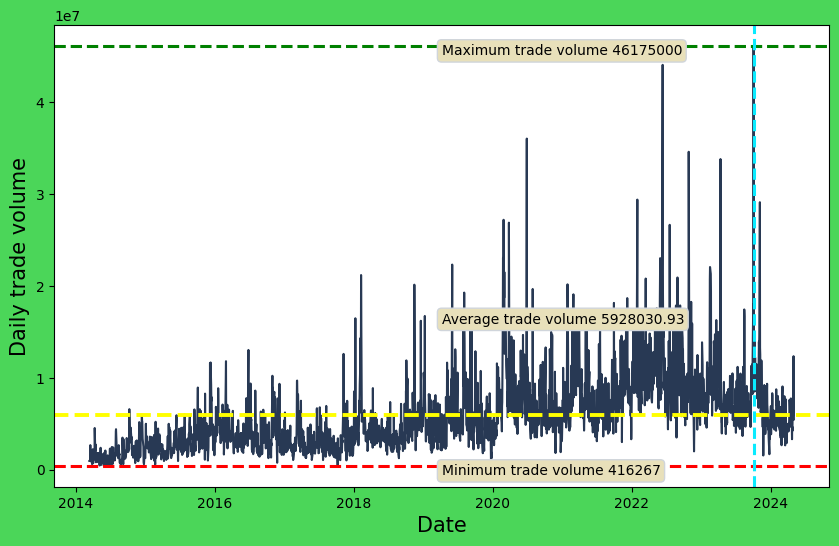

In [ ]:
def trade_vol(df):

    # x and y coords for average trade volume
    ave_x = df['Date'].mean()
    ave_y = df['Volume'].mean()
    # y coord for max trade vol
    max_y = df['Volume'].max()
    # y coord for min trade vol
    min_y = df['Volume'].min()

    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['Date'], df['Volume'], color='#283954')
    #ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['Volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['Volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['Volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['Volume'] == max_y]['Date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['Volume'].mean(),2)}",
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['Volume'].max()}",
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['Volume'].min()}", xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )

    plt.show()


# plot of all stocks trade volume
trade_vol(data)

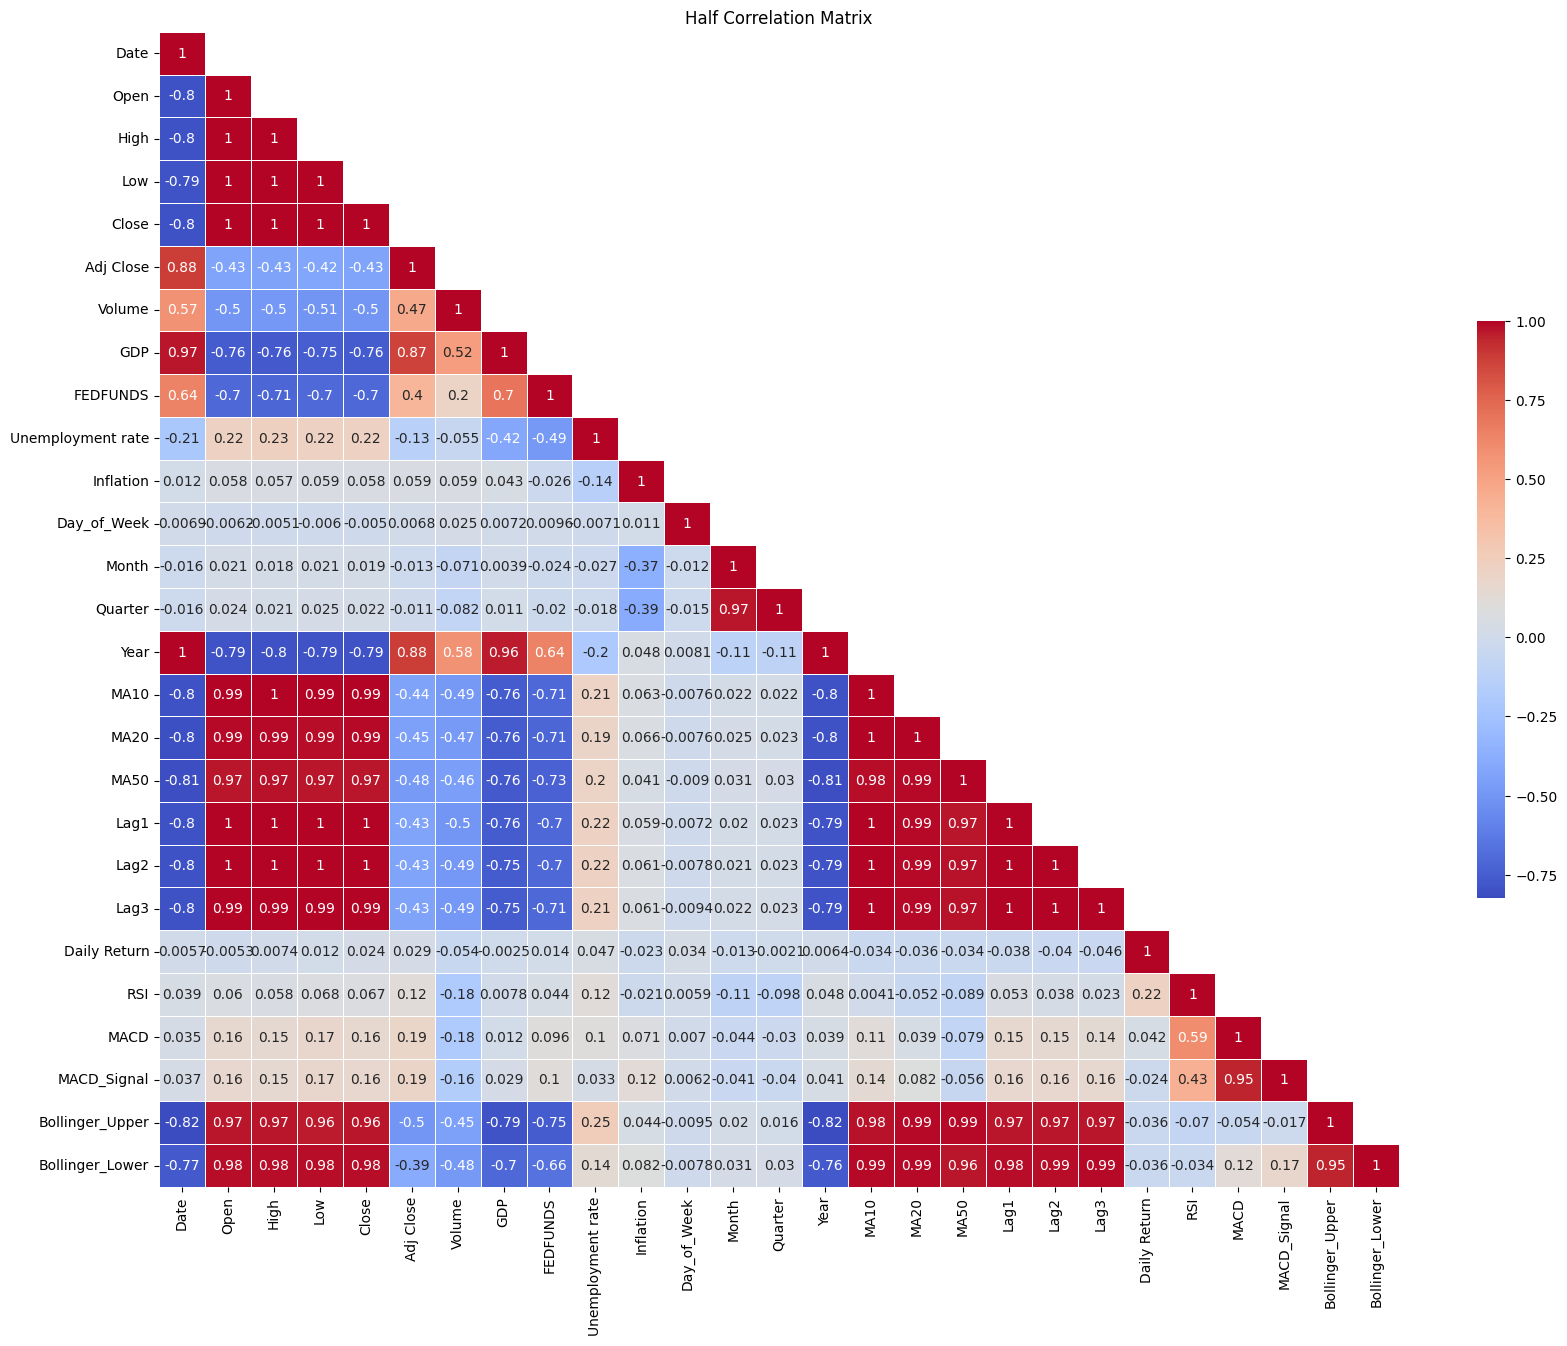

In [ ]:
# Plot correlation matrix
plt.figure(figsize=(20, 15))
corr_matrix = data.corr()
# Create a mask to display only one half of the matrix
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=~mask, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Half Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

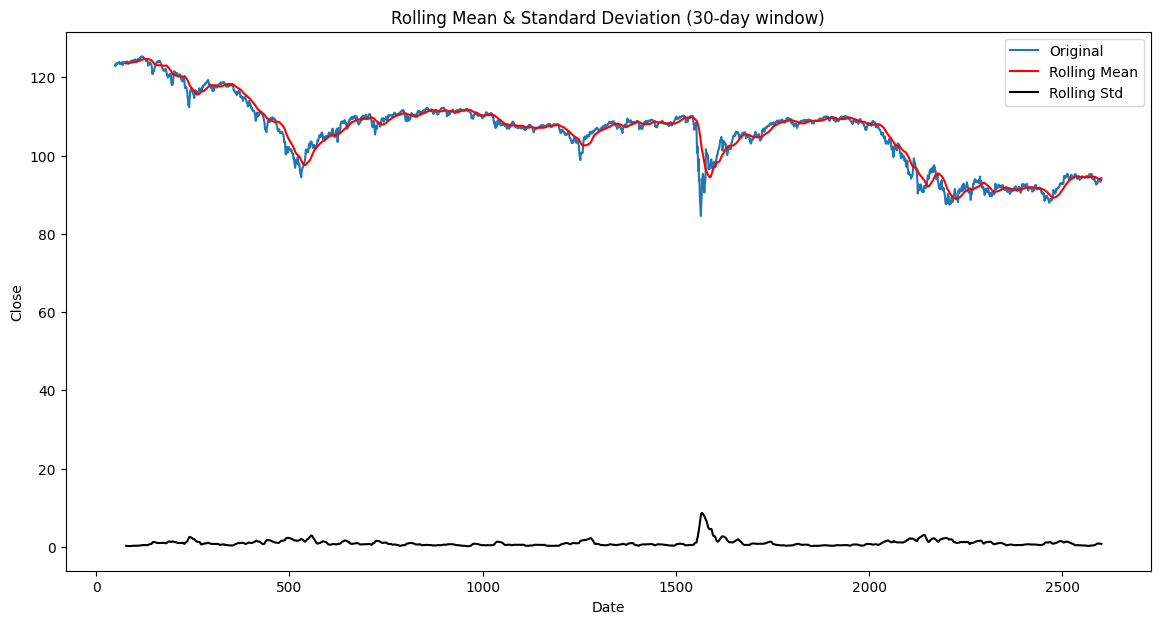

In [ ]:
# Plotting the Rolling Mean and Standard Deviation to visualize seasonality
def plot_rolling_statistics(data, column, window):
    rolling_mean = data[column].rolling(window=window).mean()
    rolling_std = data[column].rolling(window=window).std()

    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data[column], label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation ({window}-day window)')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Visualize seasonality with a 30-day rolling window
plot_rolling_statistics(data, 'Close', 30)

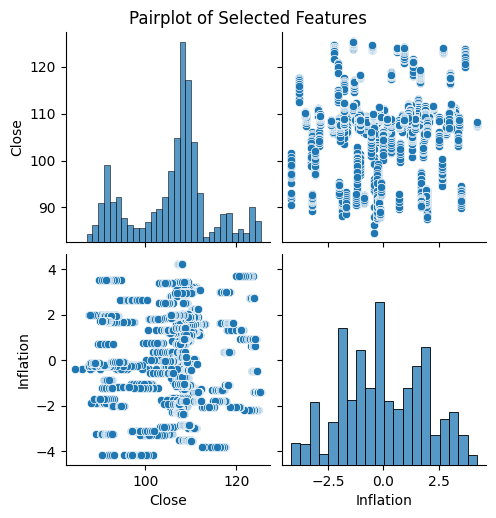

In [ ]:
# Visualizing specific correlations with pairplots
def plot_pairplot(data, columns, title):
    sns.pairplot(data[columns])
    plt.suptitle(title, y=1.02)
    plt.show()

# Pairplot for some selected features
selected_columns = ['Close', 'Inflation']
plot_pairplot(data, selected_columns, 'Pairplot of Selected Features')

In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'GDP',
       'FEDFUNDS', 'Unemployment rate', 'Inflation', 'Day_of_Week', 'Month',
       'Quarter', 'Year', 'MA10', 'MA20', 'MA50', 'Lag1', 'Lag2', 'Lag3',
       'Daily Return', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper',
       'Bollinger_Lower'],
      dtype='object')

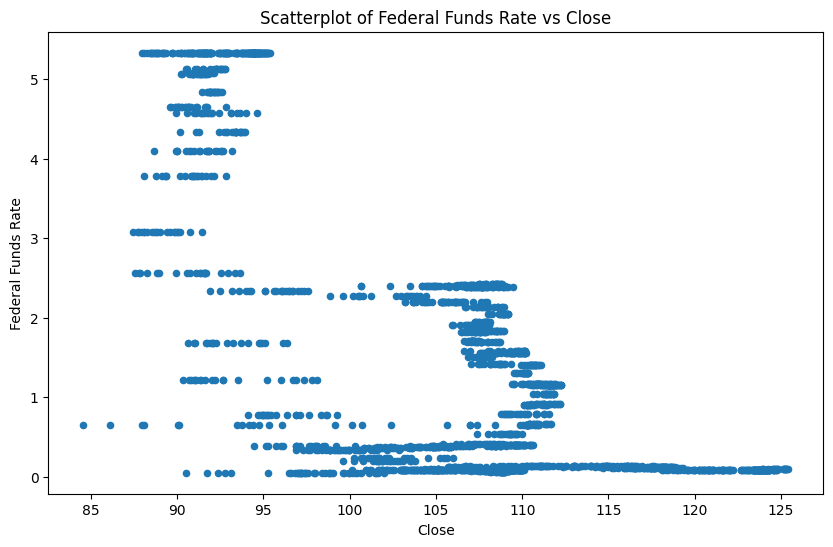

In [ ]:
# Increase figure size
plt.figure(figsize=(10, 6))  # Width and height in inches

# Create scatter plot with larger bullet points
plt.scatter(data['Close'], data['FEDFUNDS'], s=20)  # s controls marker size
plt.title('Scatterplot of Federal Funds Rate vs Close')
plt.xlabel('Close')
plt.ylabel('Federal Funds Rate')
plt.savefig('Close vs Federal Funds Rate.png')
# Display the plot
plt.show()

In [ ]:
# Function to calculate additional metrics
def calculate_metrics(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - ((1-r2) * (n-1) / (n-p-1))
    return r2, adj_r2, rmse, mse, mae, mape

## Model Implementation and Performance Analysis

Processing fold 1/5
Epoch 1/20
14/14 [==============================] - 2s 10ms/step - loss: 3290.9434
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 480.3828
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 1344.5875
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 180.6513
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 19.3057
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 2.2392
Epoch 7/20
14/14 [==============================] - 0s 10ms/step - loss: 1.6042
Epoch 8/20
14/14 [==============================] - 0s 10ms/step - loss: 1.3115
Epoch 9/20
14/14 [==============================] - 0s 10ms/step - loss: 1.1964
Epoch 10/20
14/14 [==============================] - 0s 11ms/step - loss: 1.1679
Epoch 11/20
14/14 [==============================] - 0s 12ms/step - loss: 1.1642
Epoch 12/20
14/14 [==============================] - 0s 10ms/step - loss: 1.1646
Epoch 13/

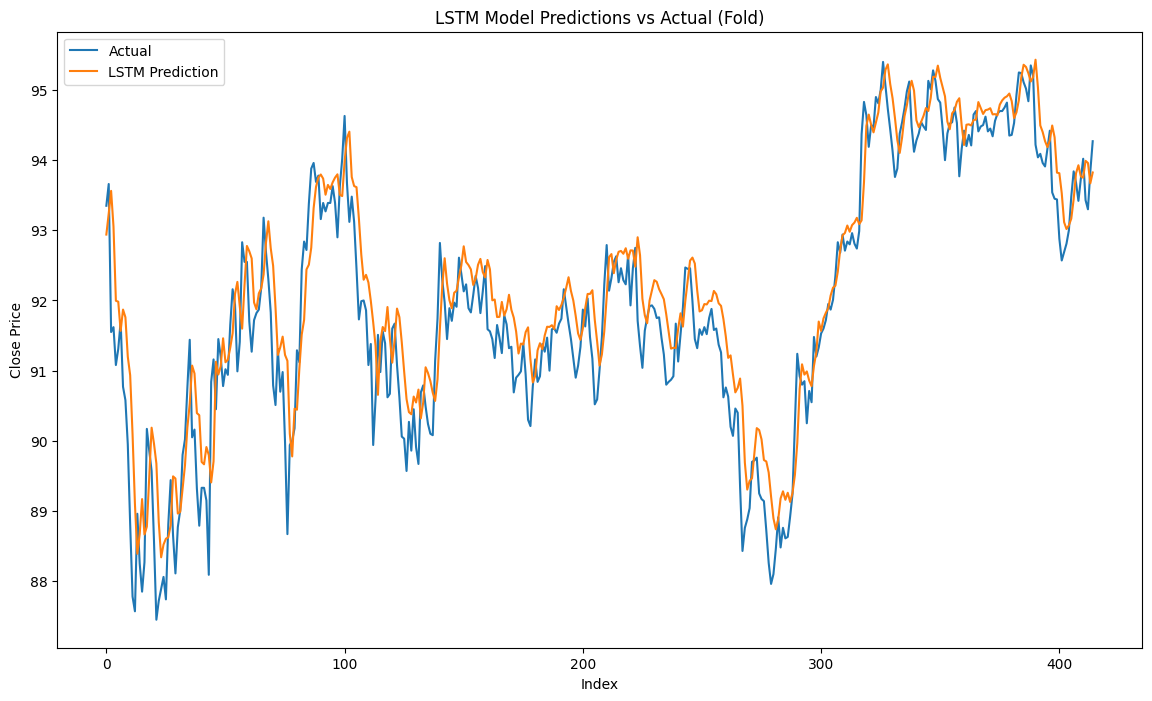

Processing fold 1/5
Epoch 1/20
14/14 [==============================] - 2s 8ms/step - loss: 13685.8145
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 9506.2295
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 3951.6299
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 122.8886
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 32.0923
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 4.7385
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 1.0124
Epoch 8/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5931
Epoch 9/20
14/14 [==============================] - 0s 10ms/step - loss: 0.4566
Epoch 10/20
14/14 [==============================] - 0s 12ms/step - loss: 0.4439
Epoch 11/20
14/14 [==============================] - 0s 10ms/step - loss: 0.4409
Epoch 12/20
14/14 [==============================] - 0s 7ms/step - loss: 0.4361
Epoch 13/20
1

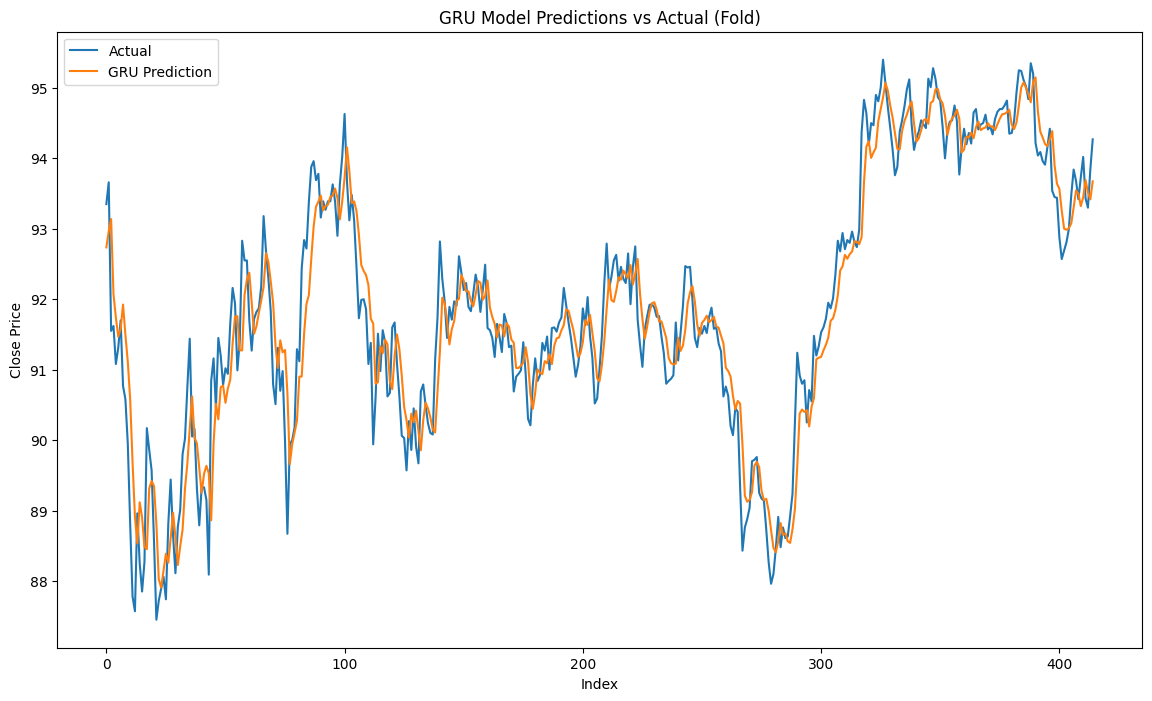

Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5


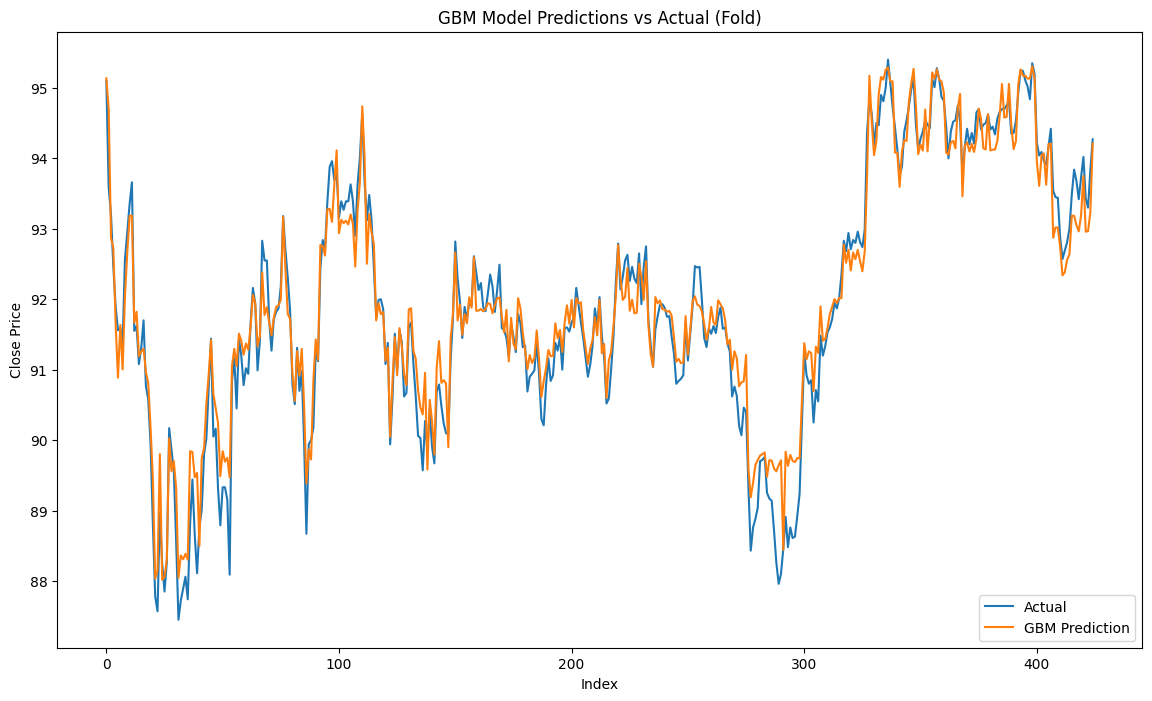

Processing fold 1/5
Train shape: (427, 27), Test shape: (425, 27)
14/14 [==============================] - 0s 3ms/step
Processing fold 2/5
Train shape: (852, 27), Test shape: (425, 27)
14/14 [==============================] - 0s 3ms/step
Processing fold 3/5
Train shape: (1277, 27), Test shape: (425, 27)
14/14 [==============================] - 0s 2ms/step
Processing fold 4/5
Train shape: (1702, 27), Test shape: (425, 27)
14/14 [==============================] - 0s 4ms/step
Processing fold 5/5
Train shape: (2127, 27), Test shape: (425, 27)
14/14 [==============================] - 0s 2ms/step


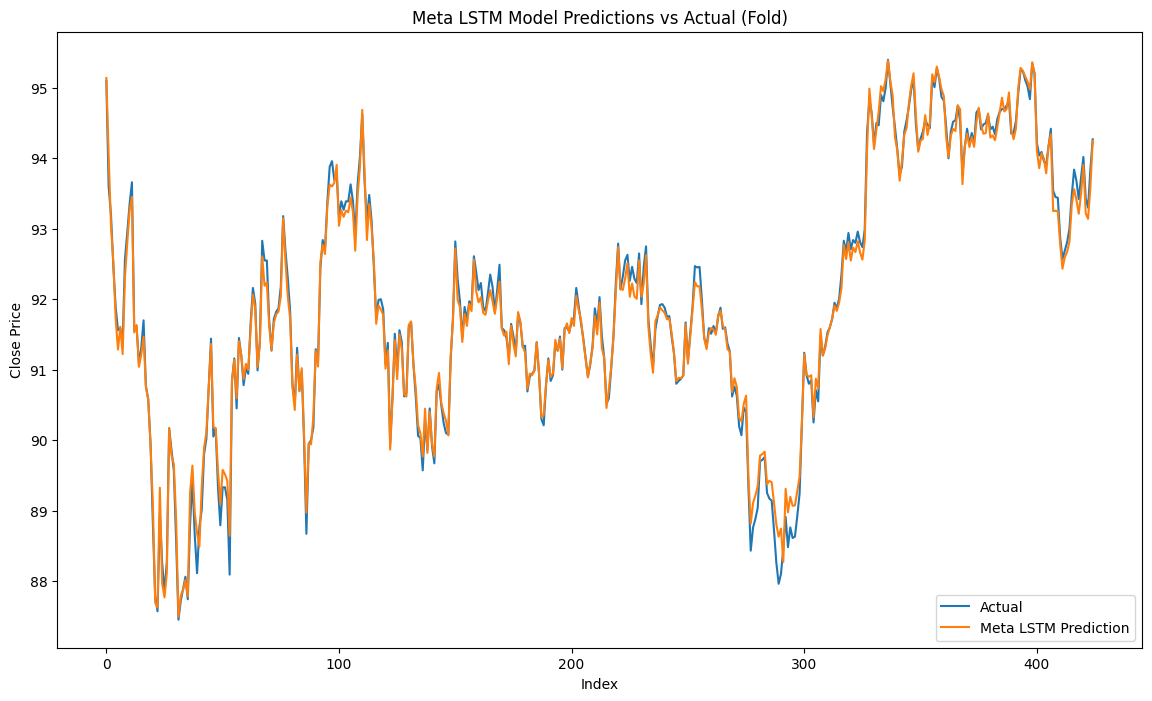

Cross-Validation Results (mean values):
                 R2  Adjusted R2      RMSE       MSE       MAE      MAPE
LSTM       0.902919     0.900516  1.016963  1.339276  0.664036  0.657577
GRU        0.943882     0.943196  0.653220  0.787881  0.515501  0.501455
GBM        0.872789     0.864819  1.043601  2.082041  0.509212  0.516126
Meta LSTM  0.970687     0.970548  0.540346  0.506642  0.327142  0.322686


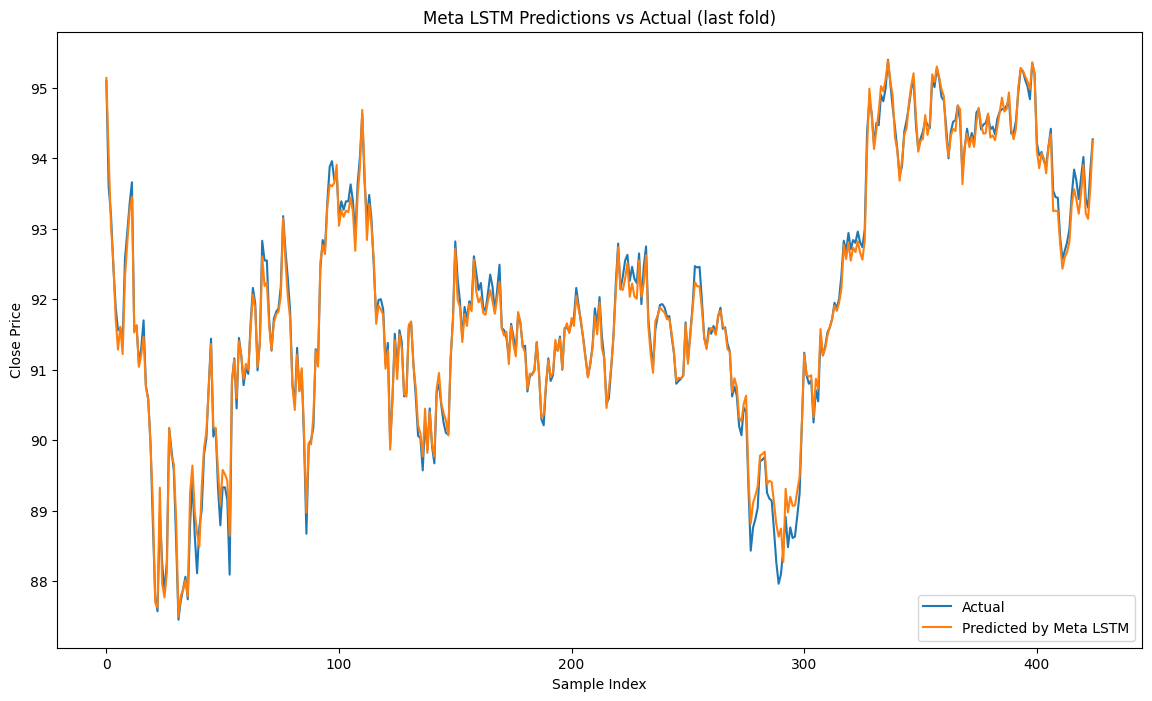

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.preprocessing.sequence import TimeseriesGenerator

# Remove rows with any missing values
data.dropna(inplace=True)

# Function to calculate additional metrics
def calculate_metrics(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - ((1-r2) * (n-1) / (n-p-1))
    return r2, adj_r2, rmse, mse, mae, mape

# Prepare data
sequence_length = 10
target = 'Close'
features = data.drop(columns=[target, 'Date']).columns

# Initialize TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize results dictionary
results_dict = {
    'LSTM': [],
    'GRU': [],
    'GBM': [],
    'Meta LSTM': []
}

# Define GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Meta Learner LSTM
def build_meta_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Cross-validation for LSTM and GRU
for model_name in ['LSTM', 'GRU']:
    for fold, (train_index, test_index) in enumerate(tscv.split(data[target].values)):
        print(f"Processing fold {fold+1}/{n_splits}")

        train, test = data[target].values[train_index], data[target].values[test_index]

        generator = TimeseriesGenerator(train, train, length=sequence_length, batch_size=1)
        X_train, y_train = [], []
        for i in range(len(generator)):
            x_, y_ = generator[i]
            X_train.append(x_)
            y_train.append(y_)
        X_train = np.array(X_train).squeeze()
        y_train = np.array(y_train)

        generator = TimeseriesGenerator(test, test, length=sequence_length, batch_size=1)
        X_test, y_test = [], []
        for i in range(len(generator)):
            x_, y_ = generator[i]
            X_test.append(x_)
            y_test.append(y_)
        X_test = np.array(X_test).squeeze()
        y_test = np.array(y_test)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Build and train the model
        if model_name == 'LSTM':
            model = build_lstm_model((sequence_length, 1))
        else:
            model = build_gru_model((sequence_length, 1))

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=20, verbose=1)

        # Make predictions
        predictions = model.predict(X_test)

        # Calculate metrics
        metrics = calculate_metrics(y_test, predictions, len(y_test), X_test.shape[1])
        results_dict[model_name].append(metrics)

        # Plot and save predictions for the last fold
        if fold == n_splits - 1:
            plt.figure(figsize=(14, 8))
            plt.plot(range(len(y_test)), y_test, label='Actual')
            plt.plot(range(len(predictions)), predictions, label=f'{model_name} Prediction')
            plt.legend()
            plt.title(f'{model_name} Model Predictions vs Actual (Fold)')
            plt.xlabel('Index')
            plt.ylabel('Close Price')
            plt.savefig(f'{model_name}_predictions.png')
            plt.show()

# Cross-validation for GBM
for fold, (train_index, test_index) in enumerate(tscv.split(data[target].values)):
    print(f"Processing fold {fold+1}/{n_splits}")

    X_train, X_test = data.iloc[train_index].drop(columns=['Close', 'Date']), data.iloc[test_index].drop(columns=['Close', 'Date'])
    y_train, y_test = data['Close'].iloc[train_index], data['Close'].iloc[test_index]

    gbm = GradientBoostingRegressor()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gbm.fit(X_train_scaled, y_train)
    gbm_pred = gbm.predict(X_test_scaled)

    # Calculate metrics
    metrics_gbm = calculate_metrics(y_test, gbm_pred, len(y_test), X_test_scaled.shape[1])
    results_dict['GBM'].append(metrics_gbm)

    # Plot and save predictions for the last fold
    if fold == n_splits - 1:
        plt.figure(figsize=(14, 8))
        plt.plot(range(len(y_test)), y_test, label='Actual')
        plt.plot(range(len(gbm_pred)), gbm_pred, label='GBM Prediction')
        plt.legend()
        plt.title('GBM Model Predictions vs Actual (Fold)')
        plt.xlabel('Index')
        plt.ylabel('Close Price')
        plt.savefig('GBM_predictions.png')
        plt.show()

# Perform cross-validation and store the results
def perform_cross_validation(data, target, features, n_splits):
    cv_results = []

    for fold, (train_index, test_index) in enumerate(tscv.split(data[target].values)):
        print(f"Processing fold {fold+1}/{n_splits}")

        train_X, train_y = data.iloc[train_index], data[target].values[train_index]
        test_X, test_y = data.iloc[test_index], data[target].values[test_index]

        print(f"Train shape: {train_X.shape}, Test shape: {test_X.shape}")

        # Reshape data for GRU
        train_X_reshaped = train_y.reshape((train_y.shape[0], 1, 1))
        test_X_reshaped = test_y.reshape((test_y.shape[0], 1, 1))

        # Train GRU
        gru_model = build_gru_model((1, 1))
        gru_model.fit(train_X_reshaped, train_y, epochs=10, verbose=0)
        gru_pred = gru_model.predict(test_X_reshaped)

        # Train GBM
        gbm_model = GradientBoostingRegressor()
        scaler = StandardScaler()
        train_X_scaled = scaler.fit_transform(train_X[features])
        test_X_scaled = scaler.transform(test_X[features])
        gbm_model.fit(train_X_scaled, train_y)
        gbm_pred = gbm_model.predict(test_X_scaled)

        # Calculate metrics for GRU and GBM
        metrics_gru = calculate_metrics(test_y, gru_pred.flatten(), len(test_y), 1)
        metrics_gbm = calculate_metrics(test_y, gbm_pred, len(test_y), test_X_scaled.shape[1])
        results_dict['GRU'].append(metrics_gru)
        results_dict['GBM'].append(metrics_gbm)

        # Prepare features for meta LSTM
        meta_features = np.hstack([gru_pred, gbm_pred.reshape(-1, 1)])
        meta_features = meta_features.reshape((meta_features.shape[0], 1, 2))

        # Train and validate Meta Learner LSTM
        meta_lstm = build_meta_lstm_model((1, 2))
        meta_lstm.fit(meta_features, test_y, epochs=20, verbose=0)
        predictions = meta_lstm.predict(meta_features)

        # Evaluate Meta Learner
        metrics_meta = calculate_metrics(test_y, predictions.flatten(), len(test_y), 2)
        results_dict['Meta LSTM'].append(metrics_meta)
        cv_results.append((test_y, predictions.flatten()))

        # Plot and save predictions for the last fold
        if fold == n_splits - 1:
            plt.figure(figsize=(14, 8))
            plt.plot(range(len(test_y)), test_y, label='Actual')
            plt.plot(range(len(predictions)), predictions.flatten(), label='Meta LSTM Prediction')
            plt.legend()
            plt.title('Meta LSTM Model Predictions vs Actual (Fold)')
            plt.xlabel('Index')
            plt.ylabel('Close Price')
            plt.savefig('Meta_LSTM_predictions.png')
            plt.show()

    return results_dict, cv_results

# Perform cross-validation and store the results
results_dict, cv_results = perform_cross_validation(data, target, features, n_splits)

# Aggregate results
mean_results_dict = {model: np.mean(results, axis=0) for model, results in results_dict.items()}
results_df = pd.DataFrame(mean_results_dict, index=['R2', 'Adjusted R2', 'RMSE', 'MSE', 'MAE', 'MAPE']).transpose()
print("Cross-Validation Results (mean values):")
print(results_df)

# Plot example of the last fold predictions
last_fold_actual, last_fold_pred = cv_results[-1]
plt.figure(figsize=(14, 8))
plt.plot(last_fold_actual, label='Actual')
plt.plot(last_fold_pred, label='Predicted by Meta LSTM')
plt.legend()
plt.title('Meta LSTM Predictions vs Actual (last fold)')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.savefig('Meta_LSTM_predictions_last_fold.png')
plt.show()
